# Libraries installation 

In [ ]:
%pip install gymnasium[classic-control]
%pip install tensorflow
%pip install matplotlib
%pip install tqdm

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from gymnasium import wrappers
from collections import deque
from tqdm import tqdm

# Agent

In [64]:
class RLAgent:
    def __init__(
        self,
        learning_rate: float = 0.1,
        initial_epsilon: float = 0.5,
        epsilon_decay: float = 0.00002,
        final_epsilon: float = 0.1,
        action_space: int = 3,
        discount_factor: float = 0.95,
        env: gym.Env = None,
        env_size: int = 100,
        
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            action_space: The number of action for the environment
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.actions = action_space
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.discrete_size = [env_size] * len(env.observation_space.high)
        self.discrete_win_size = (env.observation_space.high - env.observation_space.low) / self.discrete_size
        self.q_values = np.random.uniform(low=-2, high=0, size=(self.discrete_size + [env.action_space.n])) 

    def policy(self,state) -> int:
        state = self.get_discrete_state(state)
        return int(np.argmax(self.q_values[state]))
    

    def get_action(self, obs: np.ndarray) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        greedy = random.random() > self.epsilon

        # exploitation
        if greedy:
            # use the train net to get the action value given a state
            return self.policy(obs)

        # exploration
        else:
             return np.random.choice(self.actions)


    def get_discrete_state(self,state):
        """
        Return a discrete representation of the state, this simplify the learning process
        by reducing the complexity of the state and allow fixed size q-table
        """
        discrete_state = (state - self.env.observation_space.low) / self.discrete_win_size
        return tuple(discrete_state.astype(np.int))


    def save_qtable(
        self,
        model_name: str,
        episode: int,
    ):
        """
        Saving Q-Tables
        """
        np.save(f'./q_tables/{model_name}/{episode}-qtable.npy', self.q_values)

    def load_qtable(
        self,
        model_name: str,
        episode: str
    ):
        """
        Load Q-Table
        """

        self.q_values = np.load(f'./q_tables/{model_name}/{episode}-qtable.npy')
        

    def update(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: np.ndarray,
    ):
        """Updates the Q-value of an action."""

        # convert np.ndarray to hashable object
        obs = self.get_discrete_state(obs)
        next_obs = self.get_discrete_state(next_obs)


        # get the future q_value for the current observation
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # get the difference between current q_value and next observation
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs + (action,)]
        )

        # update the q values for the current obseervation and action
        self.q_values[obs + (action,)] = (
            self.q_values[obs + (action,)] + self.lr * temporal_difference
        )

        # store the training error, the goal is to reduce it
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """ Decay epsilon value by a constant"""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def plot_stats(self,env):
        rolling_length = 500
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        # compute and assign a rolling average of the data to provide a smoother graph
        reward_moving_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        
        axs[1].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[1].plot(range(len(training_error_moving_average)), training_error_moving_average)
        plt.tight_layout()
        plt.show()

    def plot_policy(self,actions):
        temp_action_x = list(actions.keys())

        action_labels = {0: "left", 1: "stay", 2: "right"}
        action_x = [action_labels[a] for a in temp_action_x]
        action_y = list(actions.values())

        colors = ['blue', 'green', 'orange']

        fig, ax = plt.subplots()
        ax.bar(action_x, action_y, color=colors)
        ax.set_ylabel('Ocurrences')
        ax.set_title('Actions')
        ax.legend(title='Actions policy')

        plt.show()

In [14]:
import os
def initialize_directories(model_name):
    """
    Creates new directory in ./q_tables/
    """
    # create model directory for storing models
    if not os.path.exists("q_tables/"):
        os.makedirs("q_tables/")
    
    if not os.path.exists(f'./q_tables/{model_name}'):
        os.mkdir(f'./q_tables/{model_name}')

 96%|█████████▌| 1910/2000 [00:12<00:00, 168.02it/s]

1880/2000
1900/2000


 97%|█████████▋| 1943/2000 [00:12<00:00, 154.42it/s]

1920/2000
1940/2000


100%|█████████▉| 1996/2000 [00:12<00:00, 135.86it/s]

1960/2000
1980/2000


100%|██████████| 2000/2000 [00:12<00:00, 156.10it/s]

Average reward: -120.7965, Accuracy 1.00000


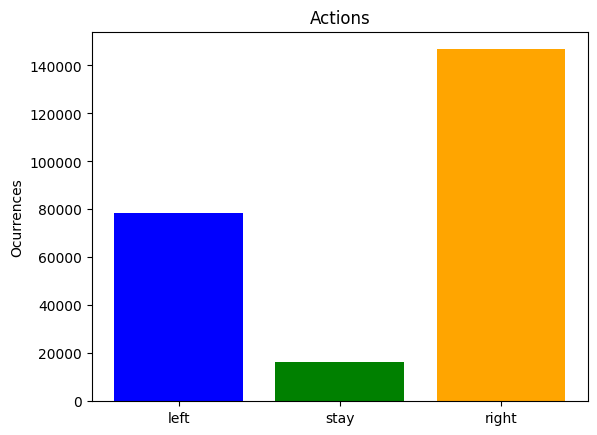

In [61]:
def training_result(model_name, episode):

  env = gym.make('MountainCar-v0')

  total_reward = 0.0
  win = 0
  episodes = 2000
  actions = {0:0,
             1:0,
             2:0}

  agent = RLAgent(env=env)
  agent.load_qtable(model_name, episode)
  

  for i in tqdm(range(episodes)): # Play 10 episode and take the average
    state, _ = env.reset()
    done = False
    truncated = False
    episode_reward = 0.0
    while not (done or truncated):
      action = agent.policy(state)

      next_state, reward, done,truncated, info = env.step(action)

      # increment action
      actions[action] += 1

      # Count number of win
      if next_state[0] >= 0.5:
        win += 1

      episode_reward += reward
      state = next_state

    if i % 20 == 0:
        print(f"{i}/{episodes}")
        
    total_reward += episode_reward

  average_reward = total_reward / episodes
  accuracy = win / episodes

  print(f"Average reward: {average_reward}, Accuracy {accuracy:.5f}")
  agent.plot_policy(actions)

model_name = f'LR: 0.1 - DISCOUNT: 0.95 -' \
             f' EPISODES: 90000'\
             f' EPSILON: 0.5'\
             f' TABLE_SIZE: 100'  

episode = "90000"

training_result(model_name,episode)

In [ ]:
EPISODES = 90_000             # number of episode to play
UPGRADE_STEP =10_000            # frequency of target network upgrade
GAMMA = 0.95                  # discount factor
LR = 0.1                      # q-table learning rate
EPS_MAX = 0.5               # Initial exploration probability
EPS_MIN = 0.1           # Final exploration probability
DECAY = EPS_MAX / (EPISODES - 1)
TABLE_SIZE = 25     # used to compute the size of the q table

reward_sum = 0
win = 0
scores = list()

model_name = f'LR: {LR} - DISCOUNT: {GAMMA} -' \
             f' EPISODES: {EPISODES}'\
             f' EPSILON: {EPS_MAX}'\
             f' TABLE_SIZE: {TABLE_SIZE}'

initialize_directories(model_name)


env = gym.make('MountainCar-v0')
agent = RLAgent(
    learning_rate=LR,
    initial_epsilon=EPS_MAX,
    epsilon_decay=DECAY,
    final_epsilon=EPS_MIN,
    action_space=env.action_space.n,
    discount_factor=GAMMA,
    env=env,
    env_size=TABLE_SIZE,
)

reward_sum = 0
time_scores = deque(maxlen=100)


env = wrappers.RecordEpisodeStatistics(env, deque_size=EPISODES)
for episode in range(1,EPISODES + 1):
    obs, info = env.reset()
    done = False

    step = 1
    # play one episode
    while not done:

        # get an action according to epsilon greedy policy
        action = agent.get_action(obs)

        # execute the action
        next_obs, reward, terminated, truncated, info = env.step(action)


        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated

        # upgrade to next obs
        obs = next_obs

        if done:

            # store current time for that episode
            time_scores.append(step)

            # compute avg score
            scores_avg = np.mean(time_scores) * -1

            if episode % 500 == 0:
                print(f"Episode {episode}/{EPISODES}, e {agent.epsilon:.6f}, avg reward {scores_avg:.2f}, state {next_obs}, time {step}")
                
            break

        # increment step
        step+=1

    # Save progress every UPGRADE STEP
    if episode % UPGRADE_STEP == 0:
        agent.save_qtable(model_name,episode)

    agent.decay_epsilon()

# plot stats
agent.plot_stats(env)